# Food Classifier

In [1]:
# install packages
!pip install --quiet fastai==2.5.2

You should consider upgrading via the '/root/miniconda/bin/python -m pip install --upgrade pip' command.


In [2]:
# import modules
from fastai.vision.all import *
import pandas as pd
import PIL
import os

In [4]:
# variables
IMAGE_DIR = 'imagery'
LABELS = ['ceviche','donuts','other']

IMAGE_RESIZE_WIDTH = 256
IMAGE_RESIZE_HEIGHT = 256
RESIZED_IMAGE_DIR = f'{IMAGE_DIR}/resized-{IMAGE_RESIZE_WIDTH}x{IMAGE_RESIZE_HEIGHT}'
OTHER_IMAGE_DIR = f'{IMAGE_DIR}/other'
NUM_IMAGES_PER_ITEM = 1000

MODEL_DIR = 'models'
RANDOM_SEED = 339
BATCH_SIZE = 32
NUM_EPOCHS = 4

In [5]:
!mkdir -p {RESIZED_IMAGE_DIR}
!mkdir -p {MODEL_DIR}
!mkdir -p {OTHER_IMAGE_DIR}

# Imagery

In [6]:
# compile 'other' images from subset of 99 non-ceviche & non-donut food categories in Food-101
food_101_categories = os.listdir('food-101/images')
food_101_categories.remove('donuts')
food_101_categories.remove('ceviche')
len(food_101_categories) # 99 categories now

FileNotFoundError: [Errno 2] No such file or directory: 'food-101/images'

In [99]:
# There will be alot more images than we need in those 'other' food folder. Let's select the first 11 images out of each
other_images = []
for item in food_101_categories:
    other_images.extend(get_image_files('food-101/images',folders=item)[:11])

In [100]:
len(other_images) #1089 images

1089

In [101]:
OTHER_IMAGE_DIR

'imagery/other'

In [102]:
# add our selection of other images to an 'other' image folder
for image in other_images:
    shutil.copy(image, OTHER_IMAGE_DIR)

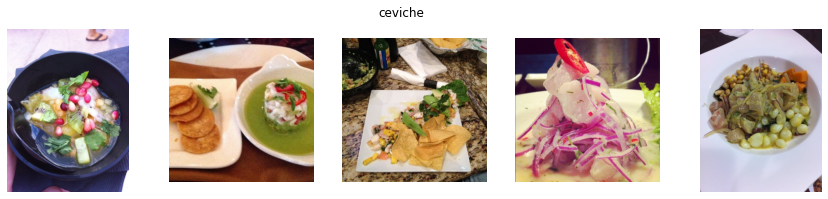

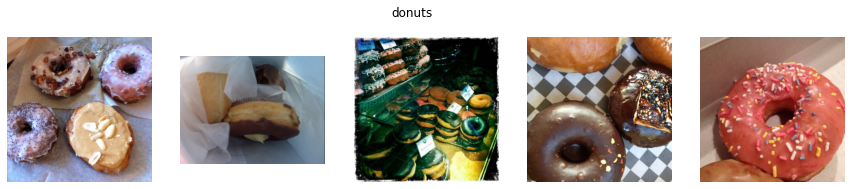

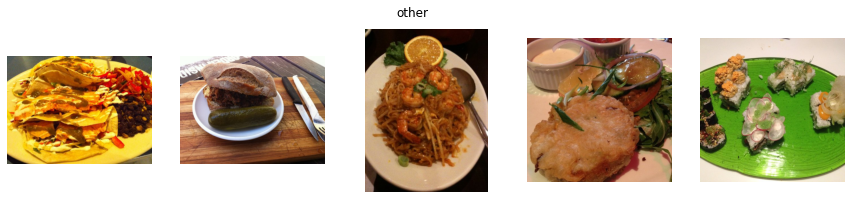

In [7]:
# inspect images
for label in LABELS:
    images = get_image_files(IMAGE_DIR, folders=label)
    sample = [load_image(image) for image in images.shuffle()[:5]]
    show_images(sample, nrows=1, ncols=5, imsize=3, suptitle=label)

In [8]:
# get list of all images

df_food = pd.DataFrame([])

for label in LABELS:
    image_paths = get_image_files(IMAGE_DIR,folders=label)[:NUM_IMAGES_PER_ITEM]
    image_ids = [p.stem for p in image_paths]
    targets = [label for i in range(NUM_IMAGES_PER_ITEM)]
    temp_df = pd.DataFrame(list(zip(image_ids,image_paths,targets)), columns=['image','image_path','target'])
    df_food = pd.concat([df_food,temp_df],ignore_index=True)

In [9]:
df_food

,image,image_path,target
0,172940,imagery/ceviche/172940.jpg,ceviche
1,3705689,imagery/ceviche/3705689.jpg,ceviche
2,217909,imagery/ceviche/217909.jpg,ceviche
3,3869358,imagery/ceviche/3869358.jpg,ceviche
4,223162,imagery/ceviche/223162.jpg,ceviche
...,...,...,...
2995,3314985,imagery/other/3314985.jpg,other
2996,3732592,imagery/other/3732592.jpg,other
2997,3888417,imagery/other/3888417.jpg,other
2998,3812105,imagery/other/3812105.jpg,other


In [10]:
df_food['resized_image_path'] = RESIZED_IMAGE_DIR + '/' + df_food['image'] + '.jpg'

In [11]:
def resize_images(df_input):
    for i in range(len(df_food)):
        current_image_path = df_input['image_path'][i]
        resized_image_path = f"{RESIZED_IMAGE_DIR}/{df_input['image'][i]}.jpg"
        image_open = PIL.Image.open(current_image_path)
        width, height = image_open.size
        if width != IMAGE_RESIZE_WIDTH or height != IMAGE_RESIZE_HEIGHT:
            resized_image = image_open.resize((IMAGE_RESIZE_WIDTH, IMAGE_RESIZE_HEIGHT), 0)
            resized_image.convert('RGB').save(resized_image_path, format='JPEG')
            #print(f"Resized image {current_image_path} with dimensions {(width, height)} to {resized_image.size}. Saved to {resized_image_path}.")

In [12]:
# resize our images and save to resized image directory
# will overwrite files if cell is run multiple times - should add an if exists statement into above function to save computation
resize_images(df_food)

In [13]:
df_food

,image,image_path,target,resized_image_path
0,172940,imagery/ceviche/172940.jpg,ceviche,imagery/resized-256x256/172940.jpg
1,3705689,imagery/ceviche/3705689.jpg,ceviche,imagery/resized-256x256/3705689.jpg
2,217909,imagery/ceviche/217909.jpg,ceviche,imagery/resized-256x256/217909.jpg
3,3869358,imagery/ceviche/3869358.jpg,ceviche,imagery/resized-256x256/3869358.jpg
4,223162,imagery/ceviche/223162.jpg,ceviche,imagery/resized-256x256/223162.jpg
...,...,...,...,...
2995,3314985,imagery/other/3314985.jpg,other,imagery/resized-256x256/3314985.jpg
2996,3732592,imagery/other/3732592.jpg,other,imagery/resized-256x256/3732592.jpg
2997,3888417,imagery/other/3888417.jpg,other,imagery/resized-256x256/3888417.jpg
2998,3812105,imagery/other/3812105.jpg,other,imagery/resized-256x256/3812105.jpg


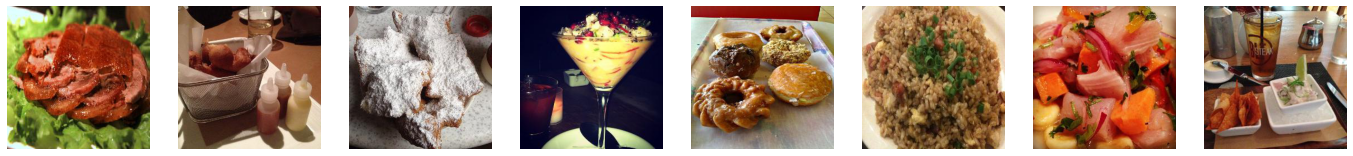

In [14]:
# duplicated code - not great, will fix later
images = get_image_files(RESIZED_IMAGE_DIR)
sample = [load_image(image) for image in images.shuffle()[:8]]
show_images(sample, nrows=1, ncols=8, imsize=3)

# Modelling

In [15]:
TIMESTAMP = datetime.now().strftime("%Y%m%d_%H%M")
print(TIMESTAMP)

20220124_2202


In [16]:
img_list = ImageDataLoaders.from_df(df_food, 
                                    path='',
                                    label_col='target', 
                                    suff='',
                                    valid_pct=0.2, 
                                    fn_col='resized_image_path',
                                    seed=RANDOM_SEED, 
                                    bs=BATCH_SIZE, 
                                    batch_tfms=aug_transforms()
                                   )

Error in magma_getdevice_arch: MAGMA not initialized (call magma_init() first) or bad device
Error in magma_getdevice_arch: MAGMA not initialized (call magma_init() first) or bad device
/root/miniconda/lib/python3.7/site-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)


Error in magma_getdevice_arch: MAGMA not initialized (call magma_init() first) or bad device
Error in magma_getdevice_arch: MAGMA not initialized (call magma_init() first) or bad device


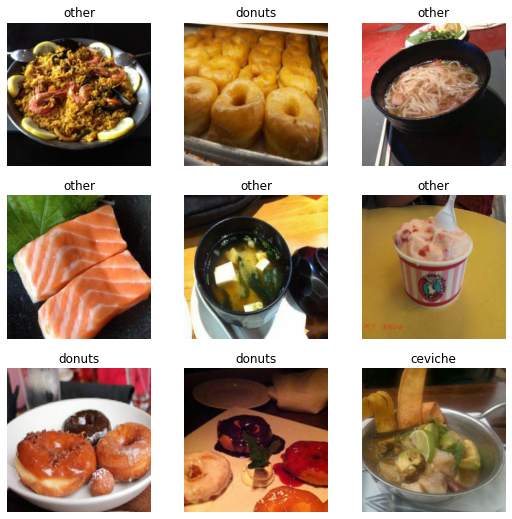

In [17]:
img_list.show_batch()

In [18]:
len(img_list.items)

2400

In [19]:
learn = cnn_learner(img_list, 
                    models.resnet50,
                    metrics=error_rate, 
                    model_dir=MODEL_DIR, 
                   )

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [20]:
learn.fit_one_cycle(NUM_EPOCHS)

epoch,train_loss,valid_loss,error_rate,time
0,0.953345,0.876940,0.223333,00:12
1,0.724926,0.685451,0.191667,00:12
2,0.437574,0.517664,0.190000,00:12
3,0.307320,0.490192,0.176667,00:12


Error in magma_getdevice_arch: MAGMA not initialized (call magma_init() first) or bad device
Error in magma_getdevice_arch: MAGMA not initialized (call magma_init() first) or bad device
Error in magma_getdevice_arch: MAGMA not initialized (call magma_init() first) or bad device
Error in magma_getdevice_arch: MAGMA not initialized (call magma_init() first) or bad device
Error in magma_getdevice_arch: MAGMA not initialized (call magma_init() first) or bad device
Error in magma_getdevice_arch: MAGMA not initialized (call magma_init() first) or bad device
Error in magma_getdevice_arch: MAGMA not initialized (call magma_init() first) or bad device
Error in magma_getdevice_arch: MAGMA not initialized (call magma_init() first) or bad device
Error in magma_getdevice_arch: MAGMA not initialized (call magma_init() first) or bad device
Error in magma_getdevice_arch: MAGMA not initialized (call magma_init() first) or bad device
Error in magma_getdevice_arch: MAGMA not initialized (call magma_init(

In [21]:
MODEL_NAME = f'food-classifier-{TIMESTAMP}'
learn.save(MODEL_NAME)

Path('models/food-classifier-20220124_2202.pth')

# Explore Results

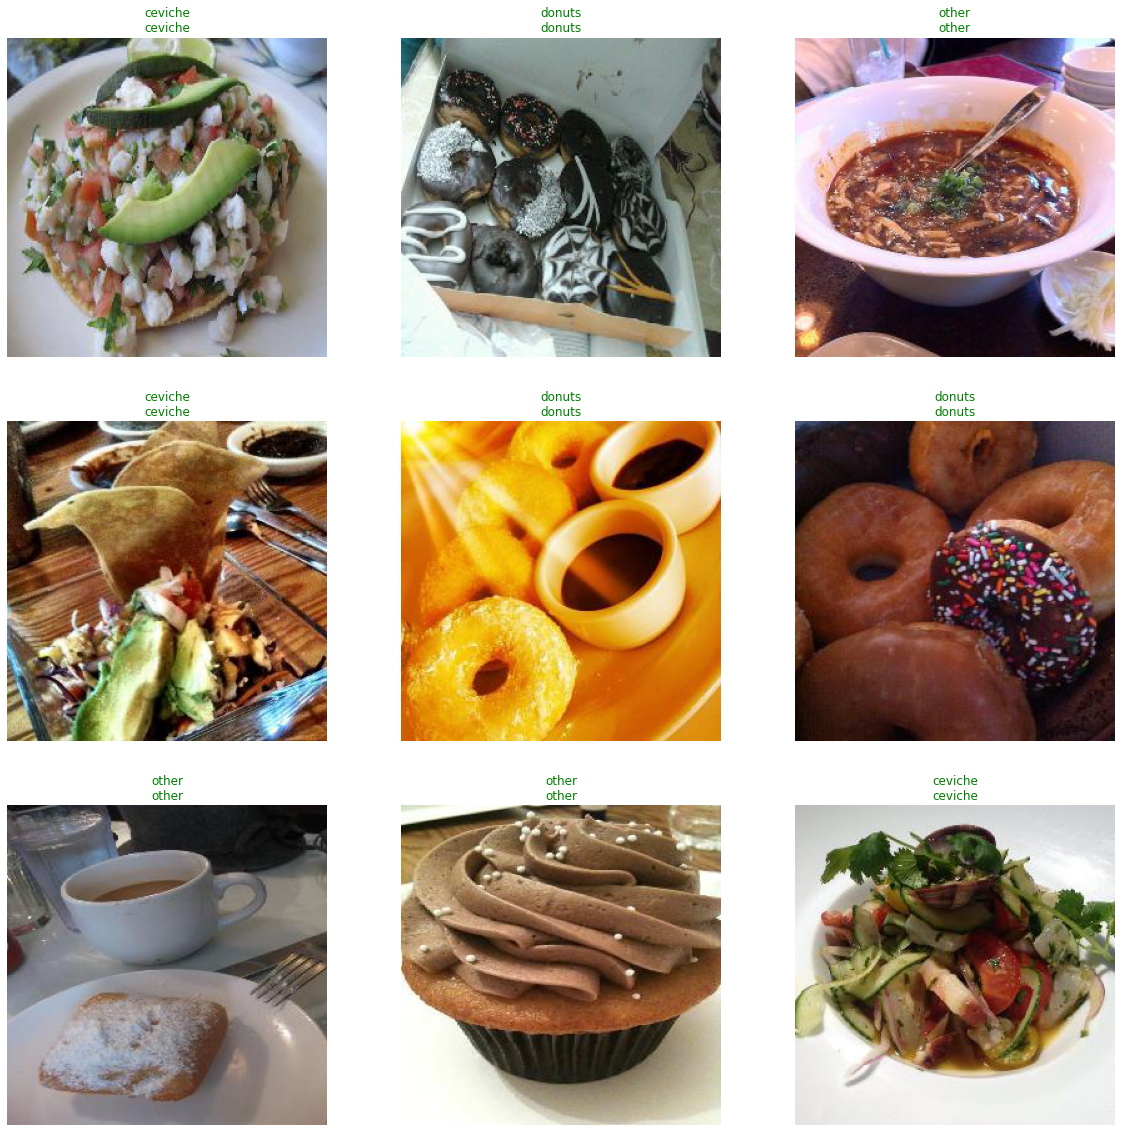

In [22]:
learn.show_results(nrows=3, figsize=(20,20))

In [23]:
# fastai interpreter for viewing & interpreting results
interpreter = ClassificationInterpretation.from_learner(learn)

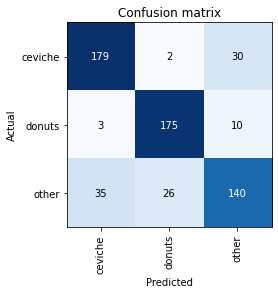

In [24]:
# let's see how well we did
conf_matrix = interpreter.plot_confusion_matrix()

#learning_interpreter.plot_top_losses(9, figsize=(15,10))